In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#/content/drive/MyDrive/Colab Notebooks/深度學習/eng-fra.txt
import unicodedata, string, re, random

In [4]:
#想把音節符號去掉
s = "Je suis tombée"
"".join(
    c for c in unicodedata.normalize('NFD', s) #拆成獨立字元
    if unicodedata.category(c) != "Mn"  #不屬於Mn(音節符號)
  )

'Je suis tombee'

In [5]:
def unicodeToAscii(s):
  return "".join(
    c for c in unicodedata.normalize('NFD', s) #拆成獨立字元
    if unicodedata.category(c) != "Mn"  #不屬於Mn(音節符號)
  )

In [6]:
s = "I'm OK." 
print(s)
s = re.sub(r"([.!?])", r" \1", s) #將符號前面加空格->用空格分割時才不會把OK和.切在一起
print(s)
s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) #要加'+',否則空集合也會滿足條件
print(s)

I'm OK.
I'm OK .
I m OK .


In [7]:
def normalizeString(s):
  s = unicodeToAscii(s.lower().strip()) #lower:小寫
  s = re.sub(r"([.!?])", r" \1", s) #將符號前面加空格->用空格分割時才不會把OK和.切在一起
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) #要加'+',否則空集合也會滿足條件
  return s

In [8]:
class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.index2word = {0:"SOS", 1:"EOS"} #SOS:start of sentence // EOS:end of sentence
    self.word2count = {} #字出現幾次
    self.n_words = 2 #有幾種字
  
  def addSentence(self, sentence):
    for word in sentence.split(" "):
      self.addword(word)
  
  def addword(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words +=1
    else:  
      self.word2count[word] += 1

In [9]:
#strip():去掉頭尾符號//split("\n"):利用換行切割
lines = open("/content/drive/MyDrive/Colab Notebooks/深度學習/eng-fra.txt", encoding = "utf-8").read().strip().split("\n")
pairs = [[normalizeString(s) for s in l.split("\t")]for l in lines]
pairs = [list(reversed(p)) for p in pairs]
input_lang = Lang("fra")
output_lang = Lang("eng")
pairs[:5]

[['va !', 'go .'],
 ['cours !', 'run !'],
 ['courez !', 'run !'],
 ['ca alors !', 'wow !'],
 ['au feu !', 'fire !']]

In [10]:
def readLangs(reverse = False):
  lines = open("/content/drive/MyDrive/Colab Notebooks/深度學習/eng-fra.txt", encoding = "utf-8").read().strip().split("\n")
  pairs = [[normalizeString(s) for s in l.split("\t")]for l in lines]
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang("fra")
    output_lang = Lang("eng")
  else:
    input_lang = Lang("eng")
    output_lang = Lang("fra")
  return input_lang, output_lang, pairs

In [11]:
MAX_LENGTH = 10
eng_prefix = (
    "i am", "i m",
    "he is", "he s",
    "you are", "you re",
    "we are", "we re",
    "they are", "they re"
)

In [12]:
def filterPair(p,reverse=False):
  if reverse:
    return len(p[0].split(" "))< MAX_LENGTH and \
    len(p[1].split(" "))< MAX_LENGTH and \
    p[1].startswith(eng_prefix)
  else:
    return len(p[0].split(" "))< MAX_LENGTH and \
    len(p[1].split(" "))< MAX_LENGTH and \
    p[0].startswith(eng_prefix)

In [13]:
def filterPairs(pairs,reverse=False):
  return [pair for pair in pairs if filterPair(pair, reverse)]

In [14]:
def prepareData(reverse=False):
  input_lang, output_lang, pairs = readLangs(reverse)
  print("Read %s sentence pairs" %len(pairs))
  pairs = filterPairs(pairs,reverse)
  print("Trimmed to %s sentence pairs" %len(pairs))
  for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
  print("counted words: ")
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  return input_lang, output_lang, pairs

In [15]:
input_lang, output_lang, pairs = prepareData(True)
print(random.choice(pairs)) #隨機挑一組看

Read 135842 sentence pairs
Trimmed to 10964 sentence pairs
counted words: 
fra 4664
eng 3024
['nous sommes ponctuelles .', 'we re punctual .']


In [16]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [17]:
use_cuda =torch.cuda.is_available()
SOS_token = 0
EOS_token = 1

In [18]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size, n_layers=1):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size
    self.n_layers = n_layers

    self.embedding = nn.Embedding(input_size,hidden_size)
    self.gru = nn.GRU(hidden_size,hidden_size)
  def forward(self, input, hidden):
    embedded = self.embedding(input).view(1,1,-1)
    output = embedded
    for i in range(self.n_layers):
      output, hidden = self.gru(output, hidden)
    return output, hidden
  
  def initHidden(self):
    result = Variable(torch.zeros(1,1,self.hidden_size))
    if use_cuda:
      return result.cuda()
    else:
      return result
      

In [19]:
class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, n_layers=1):
    super(DecoderRNN, self).__init__()
    self.n_layers = n_layers
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)
  
  def forward(self, input, hidden):
    output = self.embedding(input).view(1,1,-1) #增加兩個維度
    for i in range(self.n_layers):
      output = F.relu(output)
      output, hidden = self.gru(output, hidden)
    output = self.softmax(self.out(output[0]))
    return output, hidden

  def initHidden(self):
    result = Variable(torch.zeros(1,1,self.hidden_size))
    if use_cuda:
      return result.cuda()
    else:
      return result

In [20]:
def indexesFromSentence(lang, sentence):
  return [lang.word2index[word] for word in sentence.split(" ")]

In [21]:
def variableFromSentence(lang, sentence):
  indexes = indexesFromSentence(lang, sentence)
  indexes.append(EOS_token)
  result = Variable(torch.LongTensor(indexes).view(-1,1))
  if use_cuda:
    return result.cuda()
  else:
    return result

In [22]:
def variablesFromPair(pair):
  input_variable = variableFromSentence(input_lang, pair[0])
  output_variable = variableFromSentence(output_lang, pair[1])
  return (input_variable, output_variable)

In [23]:
teacher_forcing_ratio = 0.5

In [24]:
# training
def train(input_variable, target_variable, encoder, decoder, encoder_optimzer, decoder_optimizer, loss_fn, max_length=MAX_LENGTH):
  encoder_hidden = encoder.initHidden()
  encoder_optimzer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_variable.size()[0]
  target_length = target_variable.size()[0]

  encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
  encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
  loss = 0
  for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_variable[ei],encoder_hidden)
    encoder_outputs[ei] = encoder_output[0][0]

  decoder_input = Variable(torch.LongTensor([[SOS_token]]))
  decoder_input = decoder_input.cuda() if use_cuda else decoder_input
  decoder_hidden = encoder_hidden

  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

  if use_teacher_forcing: #不論答案為何，都會告訴你標準答案
    for di in range(target_length):
      decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)
      loss += loss_fn(decoder_output, target_variable[di])
      decoder_input = target_variable[di]
  else:
    for di in range(target_length):
      decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)
      topv, topi = decoder_output.data.topk(1)
      ni = topi[0][0]
      decoder_input = Variable(torch.LongTensor([[ni]]))
      decoder_input = decoder_input.cuda() if use_cuda else decoder_input

      loss += loss_fn(decoder_output, target_variable[di])
      if ni == EOS_token: #end of sentence
        break
  loss.backward()
  encoder_optimzer.step()
  decoder_optimizer.step()

  return loss.data / target_length 

In [25]:
import time, math

In [26]:
def asMinutes(s):
  m = math.floor(s/60) #取整數
  s -= m*60
  return "%dm %ds"%(m,s)

In [27]:
def timeSince(since, percent):
  now = time.time() #現在時間
  s = now - since #過了幾秒
  es = s/ percent #預估總花費時間
  rs = es - s #剩下時間=預估總時間-目前花費時間
  return "%s (-%s)" %(asMinutes(s), asMinutes(rs))

In [46]:
def showPlot(points):
  plt.figure() #空的圖
  #plt.subplots()  #子圖
  fig, ax = plt.subplots() 
  loc = ticker.MultipleLocator(base=0.2) #X軸分割成5塊
  ax.yaxis.set_major_locator(loc)
  plt.plot(points)

In [29]:
def trainIters(encoder, decoder, n_iters, print_every=1000, 
        plot_every=1000, learning_rate=0.01):
  start = time.time()
  plot_losses = []
  print_loss_total = 0
  plot_loss_total = 0

  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
  training_pairs = [variablesFromPair(random.choice(pairs))
            for i in range(n_iters)]
  loss_fn = nn.NLLLoss()

  for iter in range(1, n_iters+1):
    training_pair = training_pairs[iter-1]
    input_variable = training_pair[0]
    target_variable = training_pair[1]
    loss = train(input_variable,target_variable, encoder,
            decoder, encoder_optimizer, decoder_optimizer,
            loss_fn)
    print_loss_total += loss
    plot_loss_total += loss
    if iter % print_every == 0:
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print("%s (%d, %d%%) %.4f" %(timeSince(start, iter/n_iters),
                       iter, 100*iter/n_iters,
                       print_loss_avg))
    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total/plot_every
      plot_loss_total = 0
      plot_losses.append(plot_loss_avg)

  showPlot(plot_losses)

In [30]:
hidden = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden)
decoder1 = DecoderRNN(hidden, output_lang.n_words)

1m 30s (-21m 12s) (5000, 6%) 3.0132
2m 50s (-18m 28s) (10000, 13%) 2.4739
4m 8s (-16m 35s) (15000, 20%) 2.1227
5m 28s (-15m 2s) (20000, 26%) 1.8726
6m 47s (-13m 35s) (25000, 33%) 1.6747
8m 7s (-12m 11s) (30000, 40%) 1.4910
9m 27s (-10m 48s) (35000, 46%) 1.3281
10m 49s (-9m 28s) (40000, 53%) 1.2189
12m 10s (-8m 6s) (45000, 60%) 1.0569
13m 31s (-6m 45s) (50000, 66%) 0.9565
14m 51s (-5m 24s) (55000, 73%) 0.8645
16m 12s (-4m 3s) (60000, 80%) 0.7615
17m 33s (-2m 42s) (65000, 86%) 0.7003
18m 54s (-1m 21s) (70000, 93%) 0.6540
20m 15s (-0m 0s) (75000, 100%) 0.5583


<Figure size 432x288 with 0 Axes>

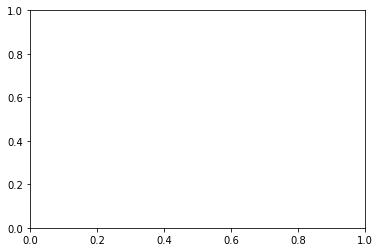

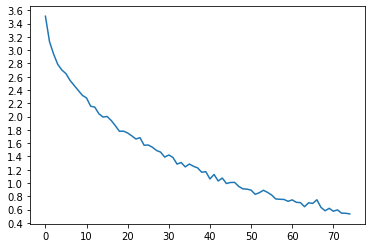

In [31]:
if use_cuda:
  encoder1 = encoder1.cuda()
  decoder1 = decoder1.cuda()
trainIters(encoder1, decoder1, 75000, print_every=5000)

In [33]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
 input_variable = variableFromSentence(input_lang, sentence)
 input_length = input_variable.size()[0]
 encoder_hidden = encoder.initHidden()

 encoder_outputs = Variable(torch.zeros(max_length,encoder.hidden_size))
 encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

 for ei in range(input_length):
   encoder_output, encoder_hidden = encoder(
       input_variable[ei], encoder_hidden)
   encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

 decoder_input = Variable(torch.LongTensor([[SOS_token]])) 
 decoder_input = decoder_input.cuda() if use_cuda else decoder_input
 decoder_hidden = encoder_hidden
 decoded_words = []

 for di in range(max_length):
  decoder_output, decoder_hidden = decoder(decoder_input,decoder_hidden)

  topv, topi = decoder_output.data.topk(1) #他都會假設是2dim tensor
  ni = topi[0][0]
  if ni == EOS_token: #end of translate
    decoded_words.append("<EOS>")
    break
  else:
    decoded_words.append(output_lang.index2word[ni.item()])

  decoder_input = Variable(torch.LongTensor([[ni]])) 
  decoder_input = decoder_input.cuda() if use_cuda else decoder_input

 return decoded_words

In [37]:
output_words = evaluate(encoder1, decoder1, 
            "je suis chatouilleux .")
print(output_words)

['i', 'm', 'ticklish', '.', '<EOS>']


In [38]:
def evaluateRandomly(encoder, decoder, n=10):
  for i in range(n):
    pair = random.choice(pairs)
    print(">", pair[0])
    print("=", pair[1])
    output_words = evaluate(encoder1, decoder1, pair[0])
    output_sentence = " ".join(output_words)
    print("<", output_sentence)
    print()

In [39]:
evaluateRandomly(encoder1,decoder1)

> je suis tres content de vous revoir .
= i m very glad to see you again .
< i m very glad to see you again . <EOS>

> je ne suis pas ta servante .
= i m not your maid .
< i m not your your . . <EOS>

> vous etes fort habile .
= you re very clever .
< you re very clever . <EOS>

> il prend facilement peur .
= he scares easily .
< he scares easily . <EOS>

> je lui ai fait balayer le sol .
= i made him sweep the floor .
< i made the way the the . <EOS>

> je commence a me sentir bete .
= i m beginning to feel stupid .
< i m starting to feel a little . <EOS>

> il parle couramment anglais .
= he speaks english fluently .
< he speaks english fluently . <EOS>

> je suis en faveur de ta proposition .
= i am in favor of your proposal .
< i am in favor of your . . <EOS>

> je suis tatillon .
= i m fussy .
< i m retired . <EOS>

> il est ici pour moi .
= he s here for me .
< he s here for me . <EOS>



Attention

In [40]:
class AttnDecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
    super(AttnDecoderRNN, self).__init__()
    self.n_layers = n_layers
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.dropout_p = dropout_p
    self.max_length = max_length

    self.embedding = nn.Embedding(self.output_size, self.hidden_size)
    self.attn = nn.Linear(self.hidden_size*2, self.max_length)
    self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
    self.dropout = nn.Dropout(self.dropout_p)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)
    self.out = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input).view(1,1,-1)
    embedded = self.dropout(embedded)

    attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]),1)),dim=1) #把兩個tensor接在一起
    attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0)) #bmm b -> batch

    output = torch.cat((embedded[0], attn_applied[0]),1)
    output = self.attn_combine(output).unsqueeze(0)
    for i in range(self.n_layers):
      output = F.relu(output)
      output, hidden = self.gru(output, hidden)

    output = F.log_softmax(self.out(output[0]),dim=1)
    return output, hidden, attn_weights  

  def initHidden(self):
    result = Variable(torch.zeros(1,1,self.hidden_size))
    if use_cuda:
      return result.cuda()
    else:
      return result

In [41]:
encoder2 = EncoderRNN(input_lang.n_words, hidden)
decoder2 = AttnDecoderRNN(hidden, output_lang.n_words)

In [42]:
def trainAttention(input_variable, target_variable, encoder, decoder, encoder_optimzer, decoder_optimizer, loss_fn, max_length=MAX_LENGTH):
  encoder_hidden = encoder.initHidden()
  encoder_optimzer.zero_grad()
  decoder_optimizer.zero_grad()

  input_length = input_variable.size()[0]
  target_length = target_variable.size()[0]

  encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
  encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
  loss = 0
  for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(input_variable[ei],encoder_hidden)
    encoder_outputs[ei] = encoder_output[0][0]

  decoder_input = Variable(torch.LongTensor([[SOS_token]]))
  decoder_input = decoder_input.cuda() if use_cuda else decoder_input
  decoder_hidden = encoder_hidden

  use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

  if use_teacher_forcing: #不論答案為何，都會告訴標準答案
    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input,decoder_hidden, encoder_outputs)
      loss += loss_fn(decoder_output, target_variable[di])
      decoder_input = target_variable[di]
  else:
    for di in range(target_length):
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input,decoder_hidden, encoder_outputs)
      topv, topi = decoder_output.data.topk(1)
      ni = topi[0][0]
      decoder_input = Variable(torch.LongTensor([[ni]]))
      decoder_input = decoder_input.cuda() if use_cuda else decoder_input

      loss += loss_fn(decoder_output, target_variable[di])
      if ni == EOS_token: #end of sentence
        break
  loss.backward()
  encoder_optimzer.step()
  decoder_optimizer.step()

  return loss.data / target_length 

In [44]:
def trainAttnIters(encoder, decoder, n_iters, print_every=1000, 
        plot_every=1000, learning_rate=0.01):
  start = time.time()
  plot_losses = [] #draw loss
  print_loss_total = 0
  plot_loss_total = 0

  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
  training_pairs = [variablesFromPair(random.choice(pairs))
            for i in range(n_iters)]
  criterion = nn.NLLLoss() #natural language loss

  for iter in range(1, n_iters+1):
    training_pair = training_pairs[iter-1]
    input_variable = training_pair[0]
    target_variable = training_pair[1]
    loss = trainAttention(input_variable,target_variable, encoder,
            decoder, encoder_optimizer, decoder_optimizer,
            criterion)
    print_loss_total += loss
    plot_loss_total += loss

    if iter % print_every == 0: #need to print
      print_loss_avg = print_loss_total / print_every
      print_loss_total = 0
      print("%s (%d, %d%%) %.4f" %(timeSince(start, iter/n_iters),
                       iter, 100*iter/n_iters,
                       print_loss_avg))
    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total/plot_every
      plot_loss_total = 0
      plot_losses.append(plot_loss_avg)

  showPlot(plot_losses)

0m 29s (-35m 54s) (1000, 1%) 3.3512
0m 51s (-31m 23s) (2000, 2%) 2.9312
1m 13s (-29m 13s) (3000, 4%) 2.7725
1m 34s (-28m 3s) (4000, 5%) 2.6656
1m 56s (-27m 15s) (5000, 6%) 2.5804
2m 18s (-26m 33s) (6000, 8%) 2.5061
2m 40s (-25m 57s) (7000, 9%) 2.4395
3m 2s (-25m 24s) (8000, 10%) 2.3748
3m 24s (-24m 56s) (9000, 12%) 2.3254
3m 45s (-24m 28s) (10000, 13%) 2.2607
4m 7s (-24m 1s) (11000, 14%) 2.1652
4m 29s (-23m 35s) (12000, 16%) 2.1890
4m 51s (-23m 9s) (13000, 17%) 2.1017
5m 13s (-22m 45s) (14000, 18%) 2.1294
5m 35s (-22m 22s) (15000, 20%) 1.9625
5m 57s (-21m 57s) (16000, 21%) 1.9246
6m 19s (-21m 34s) (17000, 22%) 1.9297
6m 41s (-21m 11s) (18000, 24%) 1.8217
7m 3s (-20m 48s) (19000, 25%) 1.7887
7m 25s (-20m 24s) (20000, 26%) 1.7138
7m 47s (-20m 1s) (21000, 28%) 1.7174
8m 9s (-19m 39s) (22000, 29%) 1.7413
8m 31s (-19m 16s) (23000, 30%) 1.6284
8m 53s (-18m 53s) (24000, 32%) 1.5769
9m 15s (-18m 30s) (25000, 33%) 1.5845
9m 37s (-18m 7s) (26000, 34%) 1.5381
9m 59s (-17m 45s) (27000, 36%) 1.5219

<Figure size 432x288 with 0 Axes>

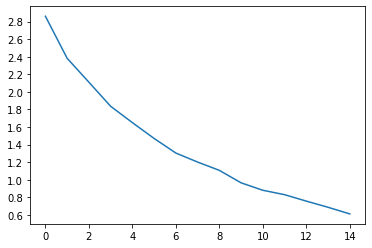

In [47]:
if use_cuda:
  encoder2.cuda()
  decoder2.cuda()

trainAttnIters(encoder2,decoder2,75000,plot_every=5000)

In [48]:
def evaluateAttn(encoder, decoder, sentence, max_length=MAX_LENGTH):
 input_variable = variableFromSentence(input_lang, sentence)
 input_length = input_variable.size()[0]
 encoder_hidden = encoder.initHidden()

 encoder_outputs = Variable(torch.zeros(max_length,encoder.hidden_size))
 encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

 for ei in range(input_length):
   encoder_output, encoder_hidden = encoder(
       input_variable[ei], encoder_hidden)
   encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

 decoder_input = Variable(torch.LongTensor([[SOS_token]])) 
 decoder_input = decoder_input.cuda() if use_cuda else decoder_input

 decoder_hidden = encoder_hidden
 decoded_words = []
 deocder_attentions = torch.zeros(max_length, max_length)


 for di in range(max_length):
  decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input,decoder_hidden, encoder_outputs)

  deocder_attentions[di] = decoder_attention.data

  topv, topi = decoder_output.data.topk(1) #他都會假設是2dim tensor
  ni = topi[0][0]
  if ni == EOS_token: #end of translate
    decoded_words.append("<EOS>")
    break
  else:
    decoded_words.append(output_lang.index2word[ni.item()])

  decoder_input = Variable(torch.LongTensor([[ni]])) 
  decoder_input = decoder_input.cuda() if use_cuda else decoder_input

 return decoded_words, deocder_attentions[:di+1]

In [49]:
def showAttention(input_sentence, output_words, attentions):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = plt.matshow(attentions.numpy(), cmap="bone")
  fig.colorbar(cax)
  ax.set_xticklabels([""]+input_sentence.split(" ")+["<EOS>"], rotation=90)
  ax.set_yticklabels([""]+output_words)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

In [50]:
def evaluateAttnRandomly(encoder, decoder, n=10):
  for i in range(n):
    pair = random.choice(pairs)
    print(">", pair[0])
    print("=", pair[1])
    output_words, attentions = evaluateAttn(encoder, decoder, pair[0])
    output_sentence = " ".join(output_words)
    print("<", output_sentence)
    print('')
    showAttention(pair[0], output_words, attentions)

> j ai dix huit ans .
= i am years old .
< i m eighteen years . <EOS>



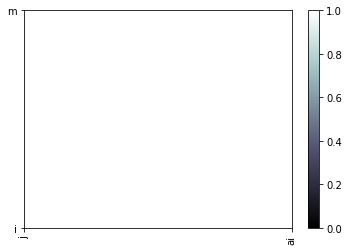

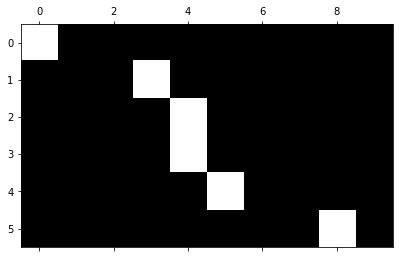

> il est endormi .
= he is asleep .
< he is asleep . <EOS>



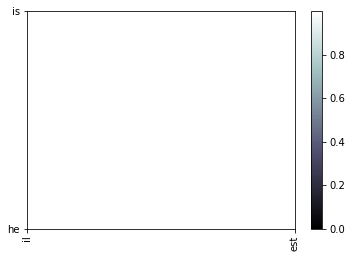

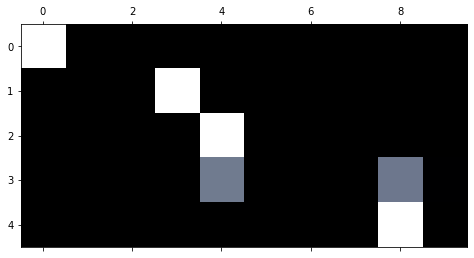

> je suis excite a l idee du demenagement .
= i m excited about the move .
< i am willing to the the the bus . <EOS>



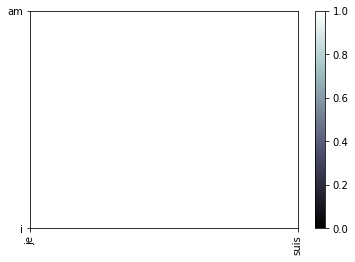

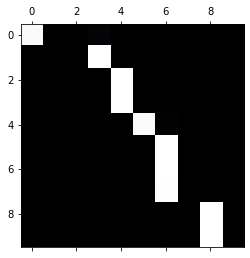

> je crains que nous perdions la partie .
= i m afraid we ll lose the game .
< i m afraid we ll lose the game . <EOS>



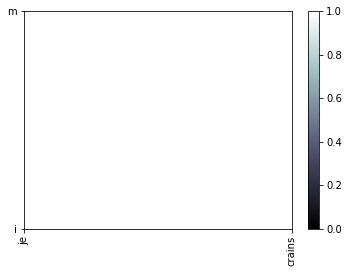

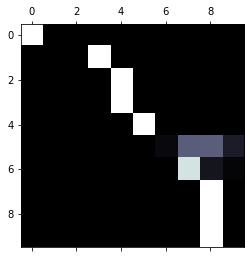

> je suis accoutume au temps froid .
= i am accustomed to cold weather .
< i am accustomed to to the cold . <EOS>



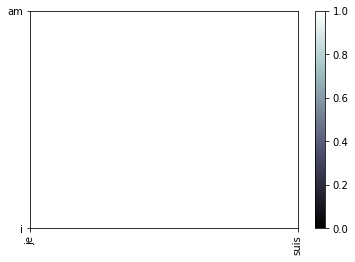

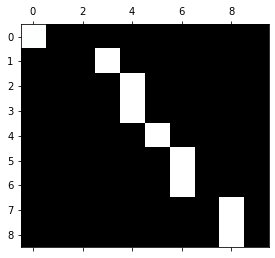

> ils sont tous a moi .
= they re all mine .
< they re all mine . <EOS>



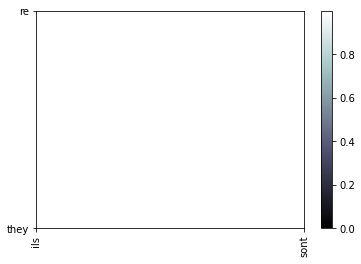

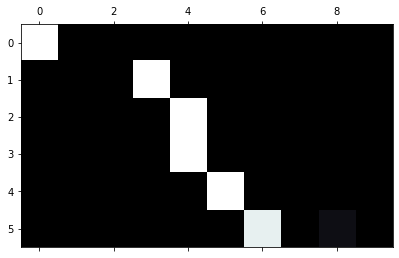

> nous ne sommes pas en securite .
= we re not safe .
< we re not safe . <EOS>



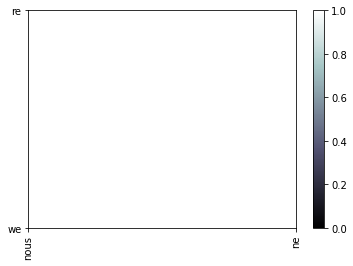

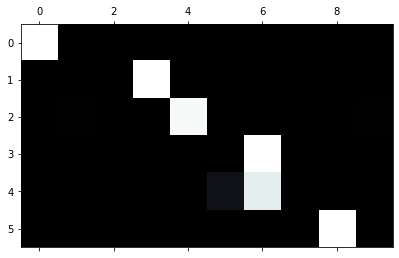

> il est experimente dans l evaluation d antiquites .
= he is experienced in valuing antiques .
< he is experienced in valuing antiques . <EOS>



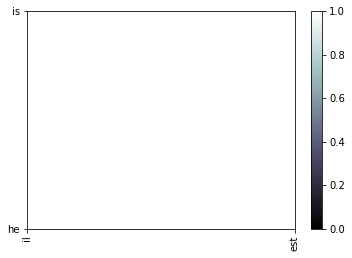

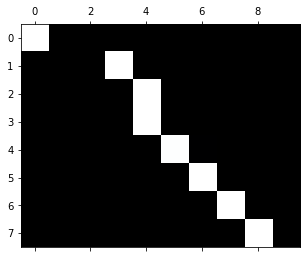

> je ne suis pas votre ennemi .
= i am not your enemy .
< i m not your enemy . <EOS>



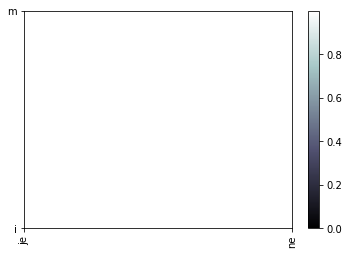

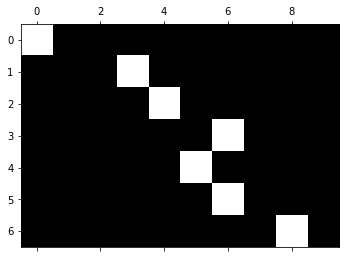

> ils le font comme il faut .
= they re doing it right .
< they re doing it right . <EOS>



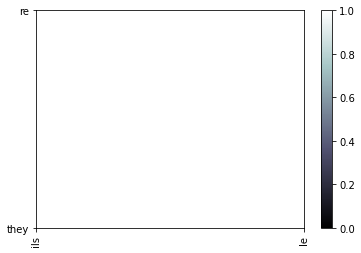

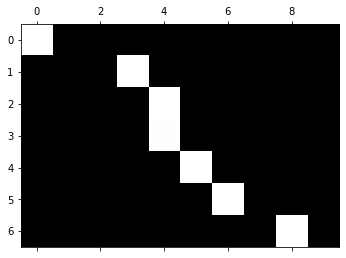

In [51]:
evaluateAttnRandomly(encoder2, decoder2)